In [1]:
import numpy as np
import xarray as xr
import intake
import xesmf as xe
import pandas as pd
import cfgrib

import warnings

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import from_levels_and_colors
from matplotlib.colors import TwoSlopeNorm, Normalize
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import seaborn as sns

warnings.filterwarnings("ignore")
%matplotlib inline


In [2]:
!ls

forcing_density.pdf	 rfmip_models.csv.gz
instantaneous_plots.pdf  rfmip_models.json
InstantaneousRF.ipynb	 sfi0014_forcing_1851.nc
PET0.ESMF_LogFile	 spaer_ensemble.pdf
rfmip_erf_lw.pdf	 SpAer_ERF.ipynb
rfmip_erf.pdf		 total_aerosol_radiative_forcing.ipynb
rfmip_intake.ipynb


In [3]:
def compute_forcings_allsky(data_aerosols, data_control):
    ''' Calculate the effective radiative forcing at TOA due shortwave and longwave radiation flux
       Parameters:
       -----------
       data_aerosols: xarray.Dataset
                 aerosol data; should include 'rsdt', 'rsut' and 'rlut' fluxes; usually: dim=(time, lat, lon) 
       data_control: xarray.Dataset
                     control data; should include 'rsdt', 'rsut' and 'rlut' fluxes and has to be of the 
                     same dimension as data_aer

       Returns:
       --------
       sw_forcing_toa: xarray.DataArray
                       shortwave forcing at toa; same dimension as input data (usually (time, lat, lon))
       lw_forcing_toa: xarray.DataArray
                       longwave forcing at toa; same dimension as input data (usually (time, lat, lon))
    '''
    
    sw_balance_aer = data_aerosols["rsdt"] - data_aerosols["rsut"]
    sw_balance_control = data_control["rsdt"] - data_control["rsut"]
    sw_forcing_toa = -sw_balance_control + sw_balance_aer
    lw_balance_aer = data_aerosols["rsdt"] - data_aerosols["rsut"] - data_aerosols["rlut"]
    lw_balance_control = data_control["rsdt"] - data_control["rsut"] - data_control["rlut"]
    lw_forcing_toa = -lw_balance_control + lw_balance_aer

    return sw_forcing_toa, lw_forcing_toa

In [4]:
# regridding to common resolution

def regridding(ds_aerosols, ds_control, periodic=True):
    regrid = xe.Regridder(ds_control, noresm_control, # which one to use?
                          method='bilinear', 
                          periodic=periodic,
                          ignore_degenerate=True)
    regridded_control = regrid(ds_control, keep_attrs=True)
    
    regrid = xe.Regridder(ds_aerosols, noresm_control, 
                          method='bilinear', 
                          periodic=periodic,
                          ignore_degenerate=True)
    regridded_aer = regrid(ds_aerosols, keep_attrs=True)
    
    regridded_params = compute_forcing_allsky(data_aerosols=regridded_aer, data_control=regridded_control)
    
    return regridded_params

In [5]:
def preprocess(ds):
    # rename variables
    ds = ds.rename({'var21':'irfstcs','var22':'irfst','var23':'irfsscs','var24':'irfss',
                    'var31':'irfltcs','var32': 'irflt','var33':'irflscs','var34': 'irfls',
                    'var73':'d_aflx_sw','var74':'d_aflx_lw','var75':'d_aflx_swcs','var76':'d_aflx_lwcs',
                    'var77':'netht_sw', 'var78':'netht_lw',
                    'var129':'geopot_surface','var134':'surface_pres','var152':'log_surface_pres',
                    'var1':'gboxarea'}
                  )
    # add variable attributes
    ds.irfstcs.attrs = {'name':'Mean instantaneous shortwave forcing at top of the atmosphere for clear sky ','units': 'W/m^2'}
    ds.irfst.attrs = {'name':'Mean instantaneous shortwave forcing at top of the atmosphere for all sky','units': 'W/m^2'}
    ds.irfsscs.attrs = {'name':'Mean instantaneous shortwave forcing at surface for clear sky','units': 'W/m^2'}
    ds.irfss.attrs = {'name':'Mean instantaneous shortwave forcing at surface for all sky','units': 'W/m^2'}
    ds.irfltcs.attrs = {'name':'Mean instantaneous longwave forcing at top of the atmosphere for clear sky','units': 'W/m^2'}
    ds.irflt.attrs = {'name':'Mean instantaneous longwave forcing at top of the atmosphere for all sky','units': 'W/m^2'}
    ds.irflscs.attrs = {'name':'Mean instantaneous longwave forcing at surface for clear sky','units': 'W/m^2'}
    ds.irfls.attrs = {'name':'Mean instantaneous longwave forcing at surface for all sky','units': 'W/m^2'}
    ds.d_aflx_sw.attrs = {'name':'Accumulated SW flux anomalies for all sky', 'units': 'W/m^2'}
    ds.d_aflx_lw.attrs = {'name':'Accumulated LW flux anomalies for all sky', 'units': 'W/m^2'}
    ds.d_aflx_swcs.attrs = {'name':'Accumulated SW flux anomalies for clear sky', 'units': 'W/m^2'}
    ds.d_aflx_lwcs.attrs = {'name':'Accumulated LW flux anomalies for clear sky', 'units': 'W/m^2'}
    ds.netht_sw.attrs = {'name':'Net SW heating rate forcing', 'units': 'K/d'}
    ds.netht_lw.attrs = {'name':'Net LW heating rate forcing', 'units': 'K/d'}
    ds.geopot_surface.attrs = {'name':'surface geopotential', 'units': 'm^2/s^2'}
    ds.surface_pres.attrs = {'name':'surface pressure','units':'Pa'}
    ds.log_surface_pres.attrs = {'name':'log surface pressure','units':'log Pa'}
    ds.gboxarea.attrs = {'name':'guassian grid','units':'m^2'}
    
    return ds

In [6]:
path = '/work/bb1198/b381265/RFMIP-IRF/'
mpiesm_irf_r1 = xr.open_mfdataset(path+'r1/*.nc', preprocess=preprocess)
mpiesm_irf_r2 = xr.open_mfdataset(path+'r2/*.nc', preprocess=preprocess)
mpiesm_irf_r3 = xr.open_mfdataset(path+'r3/*.nc', preprocess=preprocess)

In [7]:
mpiesm_irf_r3

<xarray.Dataset>
Dimensions:           (time: 348, lon: 192, lat: 96, lev: 48, nhyi: 48, nhym: 47, lev_2: 47, nsp: 2080, nc2: 2)
Coordinates:
  * time              (time) float64 1.851e+07 1.851e+07 ... 1.879e+07 1.879e+07
  * lon               (lon) float64 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * lat               (lat) float64 88.57 86.72 84.86 ... -84.86 -86.72 -88.57
  * lev               (lev) float64 1.0 2.0 3.0 4.0 5.0 ... 45.0 46.0 47.0 48.0
  * lev_2             (lev_2) float64 1.0 2.0 3.0 4.0 ... 44.0 45.0 46.0 47.0
Dimensions without coordinates: nhyi, nhym, nsp, nc2
Data variables: (12/22)
    hyai              (time, nhyi) float64 dask.array<chunksize=(12, 48), meta=np.ndarray>
    hybi              (time, nhyi) float64 dask.array<chunksize=(12, 48), meta=np.ndarray>
    hyam              (time, nhym) float64 dask.array<chunksize=(12, 47), meta=np.ndarray>
    hybm              (time, nhym) float64 dask.array<chunksize=(12, 47), meta=np.ndarray>
    irfstcs           (time, lat, lon) float32 dask.array<chunksize=(12, 96, 192), meta=np.ndarray>
    irfst             (time, lat, lon) float32 dask.array<chunksize=(12, 96, 192), meta=np.ndarray>
    ...                ...
    netht_sw          (time, lev_2, lat, lon) float32 dask.array<chunksize=(12, 47, 96, 192), meta=np.ndarray>
    netht_lw          (time, lev_2, lat, lon) float32 dask.array<chunksize=(12, 47, 96, 192), meta=np.ndarray>
    geopot_surface    (time, lat, lon) float32 dask.array<chunksize=(12, 96, 192), meta=np.ndarray>
    surface_pres      (time, lat, lon) float32 dask.array<chunksize=(12, 96, 192), meta=np.ndarray>
    log_surface_pres  (time, nsp, nc2) float32 dask.array<chunksize=(12, 2080, 2), meta=np.ndarray>
    gboxarea          (time, lat, lon) float32 dask.array<chunksize=(12, 96, 192), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    institution:  Max Planck Institute for Meteorology
    history:      Thu Nov 04 13:41:47 2021: cdo -f nc copy /work/bb1198/m3003...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [8]:
ds_mpi = xr.concat([mpiesm_irf_r1, mpiesm_irf_r2,mpiesm_irf_r3], dim='member_id')
ds = ds_mpi.mean(dim='member_id', keep_attrs=True)
ds

<xarray.Dataset>
Dimensions:           (time: 348, lon: 192, lat: 96, lev: 48, nhyi: 48, nhym: 47, lev_2: 47, nsp: 2080, nc2: 2)
Coordinates:
  * time              (time) float64 1.851e+07 1.851e+07 ... 1.879e+07 1.879e+07
  * lon               (lon) float64 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * lat               (lat) float64 88.57 86.72 84.86 ... -84.86 -86.72 -88.57
  * lev               (lev) float64 1.0 2.0 3.0 4.0 5.0 ... 45.0 46.0 47.0 48.0
  * lev_2             (lev_2) float64 1.0 2.0 3.0 4.0 ... 44.0 45.0 46.0 47.0
Dimensions without coordinates: nhyi, nhym, nsp, nc2
Data variables: (12/22)
    hyai              (time, nhyi) float64 dask.array<chunksize=(12, 48), meta=np.ndarray>
    hybi              (time, nhyi) float64 dask.array<chunksize=(12, 48), meta=np.ndarray>
    hyam              (time, nhym) float64 dask.array<chunksize=(12, 47), meta=np.ndarray>
    hybm              (time, nhym) float64 dask.array<chunksize=(12, 47), meta=np.ndarray>
    irfstcs           (time, lat, lon) float32 dask.array<chunksize=(12, 96, 192), meta=np.ndarray>
    irfst             (time, lat, lon) float32 dask.array<chunksize=(12, 96, 192), meta=np.ndarray>
    ...                ...
    netht_sw          (time, lev_2, lat, lon) float32 dask.array<chunksize=(12, 47, 96, 192), meta=np.ndarray>
    netht_lw          (time, lev_2, lat, lon) float32 dask.array<chunksize=(12, 47, 96, 192), meta=np.ndarray>
    geopot_surface    (time, lat, lon) float32 dask.array<chunksize=(12, 96, 192), meta=np.ndarray>
    surface_pres      (time, lat, lon) float32 dask.array<chunksize=(12, 96, 192), meta=np.ndarray>
    log_surface_pres  (time, nsp, nc2) float32 dask.array<chunksize=(12, 2080, 2), meta=np.ndarray>
    gboxarea          (time, lat, lon) float32 dask.array<chunksize=(12, 96, 192), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    institution:  Max Planck Institute for Meteorology
    history:      Thu Nov 04 13:25:27 2021: cdo -f nc copy /work/bb1198/m3003...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [9]:
ds.irfst

<xarray.DataArray 'irfst' (time: 348, lat: 96, lon: 192)>
dask.array<mean_agg-aggregate, shape=(348, 96, 192), dtype=float32, chunksize=(12, 96, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 1.851e+07 1.851e+07 ... 1.879e+07 1.879e+07
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 88.57 86.72 84.86 83.0 ... -83.0 -84.86 -86.72 -88.57
Attributes:
    name:     Mean instantaneous shortwave forcing at top of the atmosphere f...
    units:    W/m^2

In [10]:
# compute erf and adj
# load clt from piclim spaer aer and plclim control

In [11]:
path = '/work/bb1198/m300385/RFMIP/IRF/IPSL/piClim-spAer-anthroO3/CM616-LR-piClim-spAer-anthroO3-4-2RadCall_20140101_20431231_1M_irfstar.nc'
ipsl_irf = xr.open_dataset(path)

In [12]:
ipsl_irf

<xarray.Dataset>
Dimensions:               (lat: 143, lon: 144, presnivs: 79, time_counter: 360, axis_nbounds: 2)
Coordinates:
  * lat                   (lat) float32 90.0 88.73 87.46 ... -87.46 -88.73 -90.0
  * lon                   (lon) float32 -180.0 -177.5 -175.0 ... 175.0 177.5
  * presnivs              (presnivs) float32 1.012e+05 1.009e+05 ... 5.297 1.483
  * time_counter          (time_counter) object 2014-01-16 12:00:00 ... 2043-...
    time_centered         (time_counter) object ...
Dimensions without coordinates: axis_nbounds
Data variables:
    time_centered_bounds  (time_counter, axis_nbounds) object ...
    aire                  (lat, lon) float32 ...
    irfstar               (time_counter, lat, lon) float32 ...
Attributes:
    name:                      histmth
    description:               Created by xios
    title:                     Created by xios
    Conventions:               CF-1.6
    timeStamp:                 2019-May-03 23:59:29 GMT
    uuid:                      12dcdf9e-a910-41c6-bf2f-bd364488cee1
    LongName:                  IPSLCM6.1.6-LR
    history:                   Sat May  4 16:32:20 2019: ncrcat -C --buffer_s...
    NCO:                       "4.6.0"
    nco_openmp_thread_number:  1

In [13]:
# read in the saved json file and load the models
json_file = '/mnt/lustre01/pf/b/b381265/rfmip_analysis/rfmip_models.json'
collection = intake.open_esm_datastore(json_file)
collection.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path,opendap_url
0,RFMIP,EC-Earth-Consortium,EC-Earth3,piClim-aer,r1i1p1f1,Amon,clt,gr,NaN,v20200324,185001-185012,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/RFM...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/RFMIP...
1,RFMIP,EC-Earth-Consortium,EC-Earth3,piClim-aer,r1i1p1f1,Amon,clt,gr,NaN,v20200324,185101-185112,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/RFM...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/RFMIP...
2,RFMIP,EC-Earth-Consortium,EC-Earth3,piClim-aer,r1i1p1f1,Amon,clt,gr,NaN,v20200324,185201-185212,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/RFM...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/RFMIP...
3,RFMIP,EC-Earth-Consortium,EC-Earth3,piClim-aer,r1i1p1f1,Amon,clt,gr,NaN,v20200324,185301-185312,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/RFM...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/RFMIP...
4,RFMIP,EC-Earth-Consortium,EC-Earth3,piClim-aer,r1i1p1f1,Amon,clt,gr,NaN,v20200324,185401-185412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/RFM...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/RFMIP...


In [14]:
subset = collection.search(source_id = ['IPSL-CM6A-LR','MPI-ESM1-2-LR'],
                           experiment_id=['piClim-control','piClim-spAer-aer'],
                           variable_id=['clt', 'rsdt', 'rlut', 'rsut']
                          ) 
subset.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path,opendap_url
0,RFMIP,IPSL,IPSL-CM6A-LR,piClim-control,r1i1p1f1,Amon,clt,gr,NaN,v20181204,201401-204312,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/RFM...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/RFMIP...
1,RFMIP,IPSL,IPSL-CM6A-LR,piClim-control,r1i1p1f1,Amon,rlut,gr,NaN,v20181204,201401-204312,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/RFM...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/RFMIP...
2,RFMIP,IPSL,IPSL-CM6A-LR,piClim-control,r1i1p1f1,Amon,rsdt,gr,NaN,v20181204,201401-204312,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/RFM...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/RFMIP...
3,RFMIP,IPSL,IPSL-CM6A-LR,piClim-control,r1i1p1f1,Amon,rsut,gr,NaN,v20181204,201401-204312,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/RFM...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/RFMIP...
4,RFMIP,IPSL,IPSL-CM6A-LR,piClim-control,r2i1p1f1,Amon,clt,gr,NaN,v20181204,201401-204312,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/RFM...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/RFMIP...


In [15]:
kwargs = {
    'zarr_kwargs':{
        'consolidated':True,
        'use_cftime':True,
        'decode_times':True
    }
}
dset_dict = subset.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [16]:
[key for key in dset_dict.keys()]

['RFMIP.IPSL.IPSL-CM6A-LR.piClim-control.Amon.gr',
 'RFMIP.IPSL.IPSL-CM6A-LR.piClim-spAer-aer.Amon.gr',
 'RFMIP.MPI-M.MPI-ESM1-2-LR.piClim-control.Amon.gn',
 'RFMIP.MPI-M.MPI-ESM1-2-LR.piClim-spAer-aer.Amon.gn']

In [17]:
ipsl_control = dset_dict['RFMIP.IPSL.IPSL-CM6A-LR.piClim-control.Amon.gr'].load().mean(dim='member_id', keep_attrs=True)
ipsl_spaer = dset_dict['RFMIP.IPSL.IPSL-CM6A-LR.piClim-spAer-aer.Amon.gr'].load().mean(dim='member_id', keep_attrs=True)
#noresm_control = dset_dict['RFMIP.NCC.NorESM2-LM.piClim-control.Amon.gn'].load().mean(dim='member_id', keep_attrs=True)
#noresm_spaer = dset_dict['RFMIP.NCC.NorESM2-LM.piClim-spAer-aer.Amon.gn'].load().mean(dim='member_id', keep_attrs=True)
mpiesm_control = dset_dict['RFMIP.MPI-M.MPI-ESM1-2-LR.piClim-control.Amon.gn'].load().mean(dim='member_id', keep_attrs=True)
mpiesm_spaer = dset_dict['RFMIP.MPI-M.MPI-ESM1-2-LR.piClim-spAer-aer.Amon.gn'].load().mean(dim='member_id', keep_attrs=True)

In [18]:
# compute erf for both models

erf_mpi = compute_forcings_allsky(data_aerosols=mpiesm_spaer, data_control=mpiesm_control)[0][24:]
erf_ipsl = compute_forcings_allsky(data_aerosols=ipsl_spaer, data_control=ipsl_control)[0][12:]

In [19]:
ipsl_irf = ipsl_irf.rename_dims({'time_counter':'time'})
irf_ipsl = ipsl_irf.irfstar[12:]
irf_ipsl

<xarray.DataArray 'irfstar' (time: 348, lat: 143, lon: 144)>
[7166016 values with dtype=float32]
Coordinates:
  * lat            (lat) float32 90.0 88.73 87.46 86.2 ... -87.46 -88.73 -90.0
  * lon            (lon) float32 -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
    time_counter   (time) object 2015-01-16 12:00:00 ... 2043-12-16 12:00:00
    time_centered  (time) object 2015-01-16 12:00:00 ... 2043-12-16 12:00:00
Dimensions without coordinates: time
Attributes:
    long_name:           Instantaneous Net Shortwave Radiative Forcing at TOA...
    units:               W/m2
    online_operation:    average
    interval_operation:  900 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 900 s)

In [20]:
adj_mpi = erf_mpi.values - ds.irfst.values
adj_ipsl = erf_ipsl.values - irf_ipsl.values

In [21]:
clt_mpi = mpiesm_spaer.clt[24:] - mpiesm_control.clt[24:]
clt_ipsl = ipsl_spaer.clt[12:] - ipsl_control.clt[12:]

In [22]:
# regrid for ensemble range
# compute ensemble range

# irf -10,3 ^ -10,12
# adj -10, 15 ^ -12,10
# clt diff 4, -2.4 ^ 7,-3

In [23]:
adj_mpi.shape, adj_ipsl.shape, clt_mpi.shape, clt_ipsl.shape

((348, 96, 192), (348, 143, 144), (348, 96, 192), (348, 143, 144))

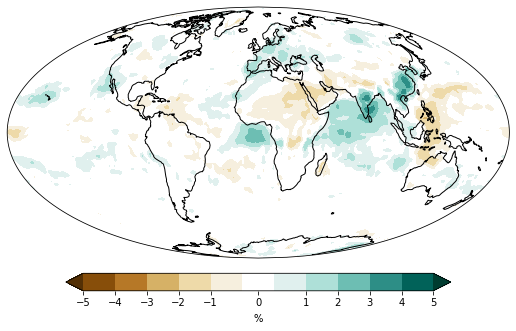

In [24]:
dataset = clt_mpi
val= np.mean(clt_mpi, axis=0) 

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(1,1,1,projection=ccrs.Mollweide())
ax.set_global()
ax.coastlines()
var, ll = add_cyclic_point(val, coord = dataset.lon) 

ticks = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
levels = [-5,-4,-3,-2,-1,-0.5,0.5,1,2,3,4,5]
colors = ["#874e0a","#b67827","#d6b166","#eedaa9","#f6efde", 'white',"#e0f0ee","#aee0d8","#6dbeb3","#2d8e86","#016259"]
normalize = mcolors.TwoSlopeNorm(vmin=-5, vmax=5, vcenter=0)

cs = ax.contourf(ll, dataset.lat, var,transform=ccrs.PlateCarree(),colors=colors,levels=levels,norm=normalize,extend='both')
plt.colorbar(cs, shrink=0.8, fraction=0.046, pad=0.04,  label=r"${\%}$", orientation='horizontal',ticks=ticks)
cs.cmap.set_under("#543005")
cs.cmap.set_over("#003c30")

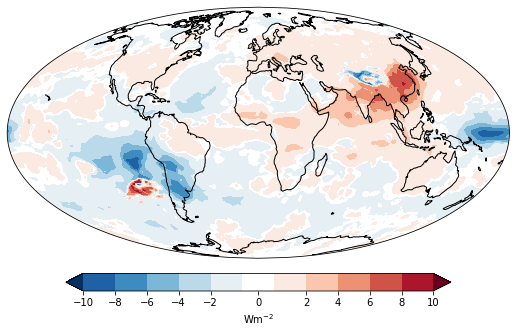

In [25]:
dataset = irf_ipsl
val= np.mean(adj_ipsl, axis=0) 

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(1,1,1,projection=ccrs.Mollweide())
ax.set_global()
ax.coastlines()
var, ll = add_cyclic_point(val, coord = dataset.lon) 

ticks = [-10, -8,-6,-4,-2,0,2,4,6,8,10] 
colors = ['#1e61a5','#3d8bbf','#7cb7d7','#bad9e9','#e6eff4','white','#faeae1','#fac7ae','#ec9274','#cf5347','#ab162a']
levels = [-10,-8,-6,-4,-2,-.2,.2,2,4,6,8,10]
normalize = mcolors.TwoSlopeNorm(vmin=-10, vmax=10, vcenter=0)

cs = ax.contourf(ll, dataset.lat, var,transform=ccrs.PlateCarree(),colors=colors,levels=levels,norm=normalize,extend='both')
plt.colorbar(cs, shrink=0.8, fraction=0.046, pad=0.04,  label=r"$\mathrm{Wm}^{-2}$", orientation='horizontal',ticks=ticks)
cs.cmap.set_under("#053061")
cs.cmap.set_over("#67001f")

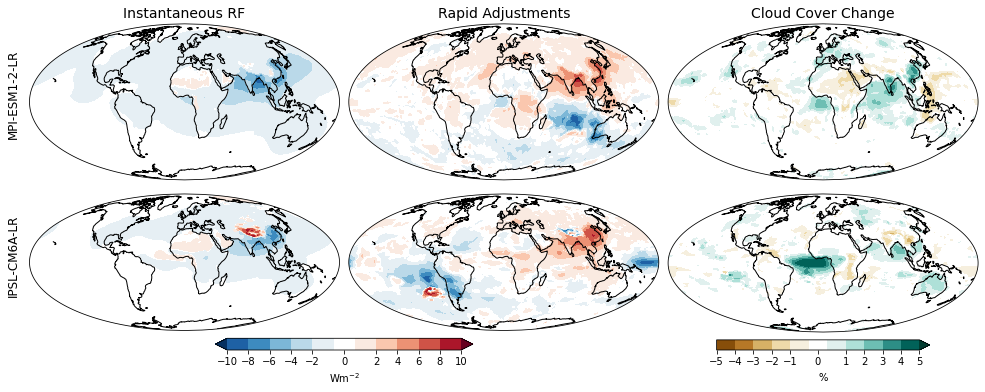

In [26]:
# plot irf, adj and clt 

fig, axes = plt.subplots(2, 3, figsize=(17,6), subplot_kw=dict(projection=ccrs.Mollweide()),constrained_layout=True)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.03, hspace=0.09)

titles = ['Instantaneous RF', 'Rapid Adjustments', 'Cloud Cover Change'] + [None]*3
labels = ['MPI-ESM1-2-LR'] + [None]*2 + ['IPSL-CM6A-LR'] + [None]*2

var = [ds.irfst,adj_mpi, clt_mpi,irf_ipsl,adj_ipsl,clt_ipsl]
dataset = [ds.irfst,ds, clt_mpi,irf_ipsl,irf_ipsl,clt_ipsl]

normalize = [mcolors.TwoSlopeNorm(vmin=-10, vmax=10, vcenter=0)]*2 + [mcolors.TwoSlopeNorm(vmin=-5, vmax=5, vcenter=0)] + [mcolors.TwoSlopeNorm(vmin=-10, vmax=10, vcenter=0)]*2 + [mcolors.TwoSlopeNorm(vmin=-5, vmax=5, vcenter=0)]

ticks_rf = [-10, -8,-6,-4,-2,0,2,4,6,8,10]
ticks_clt = [-5,-4,-3,-2,-1,0,1,2,3,4,5]

colors_rf = ['#1e61a5','#3d8bbf','#7cb7d7','#bad9e9','#e6eff4','white','#faeae1','#fac7ae','#ec9274','#cf5347','#ab162a']
colors_clt = ["#874e0a","#b67827","#d6b166","#eedaa9","#f6efde", 'white',"#e0f0ee","#aee0d8","#6dbeb3","#2d8e86","#016259"]
colors = [colors_rf]*2 + [colors_clt] + [colors_rf]*2 + [colors_clt]

levels_rf1 = [-10,-8,-6,-4,-2,-.1,.1,2,4,6,8,10]
levels_rf2 = [-10,-8,-6,-4,-2,-.5,.5,2,4,6,8,10]
levels_clt = [-5,-4,-3,-2,-1,-0.5,0.5,1,2,3,4,5]
levels = [levels_rf1] + [levels_rf2] +[levels_clt] + [levels_rf1] + [levels_rf2] +[levels_clt]

for i, ax in enumerate(fig.axes):
    ax.set_global()
    ax.coastlines(resolution='110m')
    ax.set_title(titles[i], fontsize=14)
    ax.set_aspect('auto')
    ax.text(-0.03, 0.55, labels[i], va='bottom', ha='center',rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes, fontsize=12)
    
    val, ll = add_cyclic_point(var[i], coord = dataset[i].lon)
    ax.contourf(ll, dataset[i].lat, np.mean(val, axis=0),norm =normalize[i], transform=ccrs.PlateCarree(),colors=colors[i],
                levels = levels[i],extend='both') 

cmap = mcolors.ListedColormap(colors_rf)
norm = mcolors.BoundaryNorm(levels_rf1, cmap.N)    
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

cbar = fig.colorbar(sm, ax=axes[1,:2], orientation='horizontal',label=r"$\mathrm{Wm}^{-2}$",
                    extendrect=False, extend='both', ticks=ticks_rf,
                   fraction=0.075,shrink=0.9, pad=0.05)
cbar.cmap.set_under("#053061")
cbar.cmap.set_over("#67001f")

cmap_clt = mcolors.ListedColormap(colors_clt)
norm_clt = mcolors.BoundaryNorm(levels_clt, cmap_clt.N)    
sm_clt = plt.cm.ScalarMappable(norm=norm_clt, cmap=cmap_clt)

cbar_clt = fig.colorbar(sm_clt, ax=axes[1,2], orientation='horizontal',
             label=r"${\%}$",fraction=0.065, shrink=0.9, pad=0.05,extendrect=False,
                           extend='max',ticks=ticks_clt)

cbar_clt.cmap.set_over("#003c30")
plt.savefig('instantaneous_plots.pdf',bbox_inches='tight', transparent=True)